In [1]:
#import fdb
import json
import time
import datetime
import itertools
import numpy as np
import pandas as pd
#import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,8)

# Análise do Michael

In [6]:
class item_t:
    def __init__(self, procod, prodesrdz, itvvlrtot, grpcod, seccod, grpdes):
        self.procod = int(procod)
        self.prodesrdz = prodesrdz
        self.itvvlrtot = float(itvvlrtot)
        if isinstance(grpcod, str): # parse grpcod str to int
            grpcod = int(grpcod) if len(grpcod.strip()) > 0 else np.nan
        self.grpcod = grpcod
        self.seccod = int(seccod)
        self.grpdes = grpdes

    def __str__(self):
        return '%014d %-20s %5.2f %03d %02d %-30s' % (self.procod, self.prodesrdz, self.itvvlrtot, self.grpcod, self.seccod, self.grpdes)
    
    def __eq__(self, other):
        return self.procod == other.procod
    
    def __lt__(self, other):
        return self.procod < other.procod
    
    def to_dict(self):
        return {'procod':self.procod, 'prodesrdz':self.prodesrdz, 'itvvlrtot':self.itvvlrtot, 'grpcod':self.grpcod, 'seccod':self.seccod, 'grpdes':self.grpdes}

class cupom_t:
    def __init__(self, trndat, cxanum, trnseq):
        self.trndat = trndat
        self.cxanum = cxanum
        self.trnseq = trnseq        
        self.items = []        

    def append_item(self, item):
        self.items.append(item)

    def __str__(self):
        s = str(self.trndat) + (' %03d  %06d\n' % (self.cxanum, self.trnseq))
        for item in self.items:
            s += '   ' + str(item) + '\n'
        return s

    def __eq__(self, other):
        return self.trndat == other.trndat and self.cxanum == other.cxanum and self.trnseq == other.trnseq
    
    def join_items(self):
        """Join duplicated items (same procod) by adding itvvlrtot"""
        items = {}
        for item in self.items:
            if item.procod not in items:
                items[item.procod] = item
            else:
                items[item.procod].itvvlrtot += item.itvvlrtot
        self.items = items.values()
        
    def vlrtot(self):
        vlr = 0
        for item in items:
            vlr += item.itvvlrtot
        return vlr
        
    def to_dict(self):
        items = []
        for item in self.items:
            items.append(item.to_dict())
        return {'trndat':str(self.trndat), 'cxanum':self.cxanum, 'trnseq':self.trnseq, 'items':items}
    
    
def parse_cupons_from_fdb(cur):
    """Creates a list CUPONS of cupom_t objects and dictionary PRODES with prodesrdz for each procod."""
    print('parse_cupons')
    tic = time.time()
    CUPONS = []
    PRODES = {}
    for row in cur:
        cupom = cupom_t(row[0], int(row[1]), int(row[2]))        
        item = item_t(row[3], row[4], row[5], row[6], row[7], row[8])
        PRODES[item.procod] = {'prodesrdz':item.prodesrdz, 'grpdes':item.grpdes}
        if len(CUPONS) > 0 and CUPONS[-1] == cupom:
            cupom = CUPONS[-1] # using the last created cupom
        else:
            CUPONS.append(cupom) # add new cupom
        cupom.append_item(item)
    # removing duplicated items on the same cupom
    qtd_del_items = 0
    for cupom in CUPONS:
        len_old = len(cupom.items)
        cupom.join_items()
        qtd_del_items += len_old - len(cupom.items)
    print('   Duplicated items in cupom ... %d (removed)' % qtd_del_items)    
    print('   Number of cupons ............ %d' % len(CUPONS))
    print('   Number of unique procods .... %d' % len(PRODES))
    print('Time elapsed %3.2f secs' % (time.time() - tic))
    return CUPONS, PRODES

def dump_json(CUPONS, PRODES, fname):
    print('dump_json ' + fname)
    data = {'CUPONS':[cupom.to_dict() for cupom in CUPONS], 'PRODES':PRODES}
    tic = time.time()
    with open(fname, 'w') as fid:
        fid.write(json.dumps(data, sort_keys=True, indent=3))
    print('Time elapsed %3.2f secs' % (time.time() - tic))
    
def load_json(fname):
    print('load_json ' + fname)
    tic = time.time()
    with open(fname, 'r') as fid:
        data = json.loads(fid.read())
        cupons = data['CUPONS']
        prodes = data['PRODES']
    # parse cupons
    CUPONS = []
    for cupom in cupons:
        # parse string to datetime 2019-10-01 00:00:00        
        trndat = datetime.datetime.strptime(cupom['trndat'], '%Y-%m-%d %H:%M:%S')
        c = cupom_t(trndat, cupom['cxanum'], cupom['trnseq'])
        for item in cupom['items']:
            c.append_item(item_t(item['procod'], item['prodesrdz'], item['itvvlrtot'], item['grpcod'], item['seccod'], item['grpdes']))
        CUPONS.append(c)
    # parse prodes
    PRODES = {}
    for procod in prodes:
        PRODES[int(procod)] = prodes[procod]
    print('Time elapsed %3.2f secs' % (time.time() - tic))
    return CUPONS, PRODES

In [7]:
# deserialization from json
CUPONS, PRODES = load_json('data.json')
print('[TOP PRODES]')
for k, procod in enumerate(PRODES):
    print('   %08d %-20s %-30s' % (procod, PRODES[procod]['prodesrdz'], PRODES[procod]['grpdes']))
    if k > 4:
        break
print('\n[TOP CUPONS]')
for k, cupom in enumerate(CUPONS):
    print('%s' % str(cupom))
    if k > 4:
        break

load_json data.json
Time elapsed 1.31 secs
[TOP PRODES]
   00000250 PALIS NOBRE TABUADA  MATERIAL ESCOLAR              
   00000255 PAPEL CREPOM NOVA PR MATERIAL ESCOLAR              
   00000256 BORRACHA FALTANDO    MATERIAL ESCOLAR              
   00000257 TINTA P/ TECIDO ACRI MATERIAL ESCOLAR              
   00000263 FDA ADT BIGFRAL CONF HIGIENE CORPORAL              
   00000281 FUNIL COM ALCA PEQUE PLASTICOS                     

[TOP CUPONS]
2019-10-01 00:00:00 001  460297
   07897664130319 DET L MINUANO MR 500  1.49 001 06 LOUCA                         

2019-10-01 00:00:00 001  460298
   00000000001560 COSTELA PA           21.00 002 14 BOVINO CAIXARIA               
   00000000001661 CARRE SUINO KG       13.61 003 14 SUINOS                        
   00000000005478 LANC CHESTER PERDIGA  1.74 002 10 PRESUNTO                      
   07891132019281 TEMP SAZ FL CARN.60G  3.89 005 02 TEMPEROS                      
   07893000980006 MARG.DELINE 500G      7.98 004 09 MARGARINA     

2019-10-01 00:00:00 	month_day: 01	week_day: 02



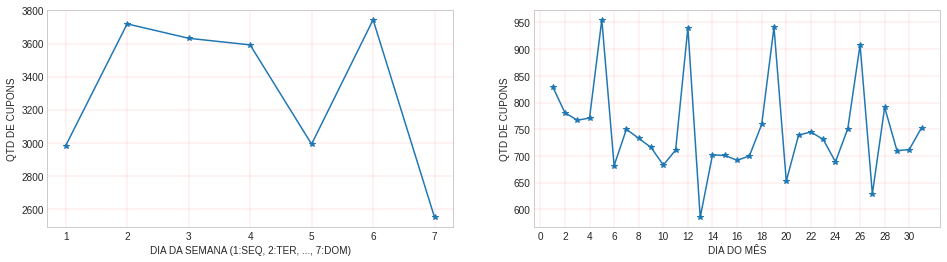

In [8]:
# calculating the number of cupons per day of week and month
qtd_week_day = np.zeros(7, dtype=int)
qtd_month_day = np.zeros(31, dtype=int)
print_first_day = True
for cupom in CUPONS:
    trndat = cupom.trndat
    qtd_week_day[trndat.weekday()] += 1
    qtd_month_day[trndat.day-1] += 1
    if trndat.day==1 and print_first_day:
        print_first_day = False
        print(trndat, '\tmonth_day: %02d\tweek_day: %02d' % (trndat.day, trndat.weekday()+1))

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
x = np.arange(1, 8)
plt.plot(x,qtd_week_day,'-*')
plt.xlabel('DIA DA SEMANA (1:SEQ, 2:TER, ..., 7:DOM)')
plt.ylabel('QTD DE CUPONS')
plt.grid(color='r', linestyle='-', linewidth=0.1)

plt.subplot(1,2,2)
x = np.arange(1,len(qtd_month_day)+1)
plt.plot(x,qtd_month_day,'-*')
plt.xlabel('DIA DO MÊS')
plt.ylabel('QTD DE CUPONS')
plt.grid(color='r', linestyle='-', linewidth=0.1)
plt.xticks(np.arange(0, np.max(x), step=2))
print('')


mean(T): 6.098234, median(T): 3.000000, std(T): 8.800802


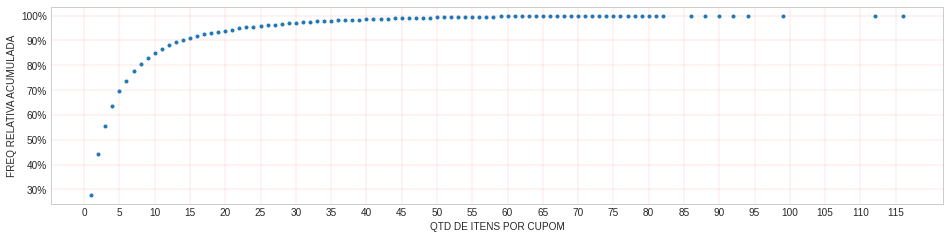

In [9]:
# histograma do numero de itens por cupom
T = [len(cupom.items) for cupom in CUPONS] #

from matplotlib.ticker import PercentFormatter

print('mean(T): %f, median(T): %f, std(T): %f' % (np.mean(T), np.median(T), np.std(T)))

plt.figure(figsize=(16,8))

Q = {q:0 for q in np.unique(T)}
for q in T:
    Q[q] += 1
x, y = sorted(Q.keys()), []
for q in Q:    
    y.append(Q[q])
y = np.cumsum(y) / np.sum(y)
plt.subplot(2,1,2)
plt.plot(x,y, '.')
plt.xlabel('QTD DE ITENS POR CUPOM')
plt.ylabel('FREQ RELATIVA ACUMULADA')
plt.xticks(np.arange(0, np.max(x), step=5))
plt.grid(color='r', linestyle='-', linewidth=0.1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [12]:
# Calcutating the number of occurrencies (cupons) of each item.
# ITEM_QTD_VDA[procod] : number of occurrencies (cupons) of procod
ITEM_QTD_VDA = {procod:{'procod':procod, 'qtd':0} for procod in PRODES}
for cupom in CUPONS:
    for item in cupom.items:
        ITEM_QTD_VDA[item.procod]['qtd'] += 1
# convert dict to sorted list
ITEM_QTD_VDA = sorted(ITEM_QTD_VDA.values(), reverse=True, key=lambda u:u['qtd'])
print('RANK     PROCOD             ITEM                       GRPDES                QTD    FREQ(%)')
print('==== ============== =====================  ==============================  =======  ======')
N = len(CUPONS)
for k, item in enumerate(ITEM_QTD_VDA):
    procod = item['procod']
    print('[%02d] %014d %-20s   %-30s %6d     %4.2f' % (k+1, procod, PRODES[procod]['prodesrdz'], PRODES[procod]['grpdes'], item['qtd'], 100 * item['qtd']/N))
    if k == 9:
        break

RANK     PROCOD             ITEM                       GRPDES                QTD    FREQ(%)
==== ============== =====================  ==============================  =======  ======
[01] 00000000001044 CEBOLA BRANCA KG       LEGUMES                          2164     9.32
[02] 00000000001456 TOMATE EXTRA KG        FRUTAS                           1927     8.30
[03] 00000000001056 BATATA INGLESA KG      LEGUMES                          1483     6.39
[04] 00000000001024 PIMENTAO KG            LEGUMES                          1418     6.11
[05] 07896725200114 ACU OLHO D AGUA 1KG    ACUCAR                           1386     5.97
[06] 00000000003184 ARROZ BEM CASEIRO 1K   ARROZ                            1361     5.86
[07] 00000000001017 ALHO GRANDE KG         VERDURAS                         1330     5.73
[08] 07896510100094 LTE MARANG 1L INT      LEITE UHT                        1328     5.72
[09] 07896242200048 OLEO DE SOJA ABC 900   OLEOS                            1250     5.39
[10] 00

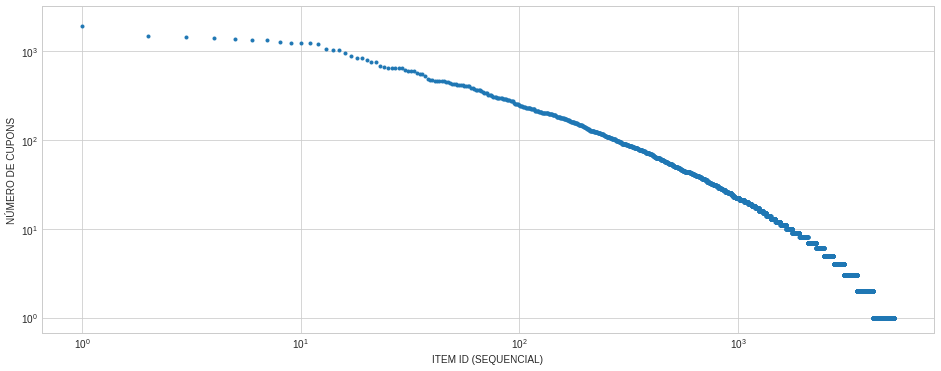

In [13]:
q = [item['qtd'] for item in ITEM_QTD_VDA]

plt.figure(figsize=(16,6))
plt.loglog(q, '.')
plt.xlabel('ITEM ID (SEQUENCIAL)')
plt.ylabel('NÚMERO DE CUPONS')
print('')

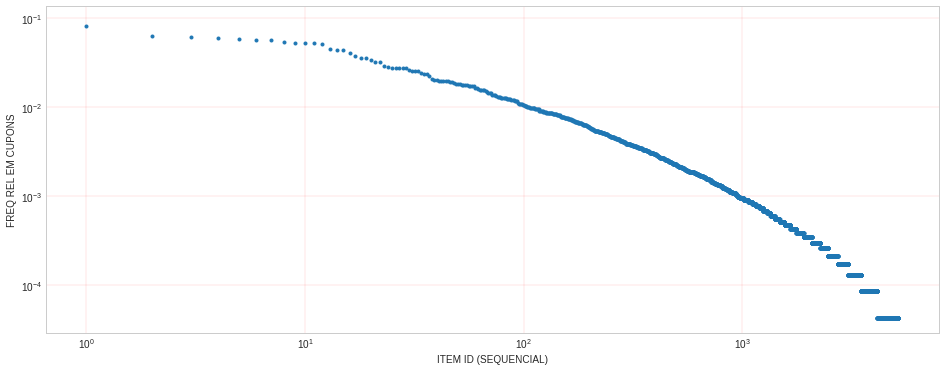

In [14]:
q = np.array([item['qtd'] for item in ITEM_QTD_VDA])

plt.figure(figsize=(16,6))
plt.loglog(q/len(CUPONS), '.')
plt.xlabel('ITEM ID (SEQUENCIAL)')
plt.ylabel('FREQ REL EM CUPONS')
plt.grid(color='r', linestyle='-', linewidth=0.1)
print('')

# Agrupamento Tito 

In [15]:
jsonFile = open('data.json', 'r')
cupons_json = json.load(jsonFile)
jsonFile.close()
cupons_json

{'CUPONS': [{'cxanum': 1,
   'items': [{'grpcod': '001',
     'grpdes': 'LOUCA',
     'itvvlrtot': 1.49,
     'procod': 7897664130319,
     'prodesrdz': 'DET L MINUANO MR 500',
     'seccod': 6}],
   'trndat': '2019-10-01 00:00:00',
   'trnseq': 460297},
  {'cxanum': 1,
   'items': [{'grpcod': '002',
     'grpdes': 'BOVINO CAIXARIA',
     'itvvlrtot': 21.0,
     'procod': 1560,
     'prodesrdz': 'COSTELA PA',
     'seccod': 14},
    {'grpcod': '003',
     'grpdes': 'SUINOS',
     'itvvlrtot': 13.61,
     'procod': 1661,
     'prodesrdz': 'CARRE SUINO KG',
     'seccod': 14},
    {'grpcod': '002',
     'grpdes': 'PRESUNTO',
     'itvvlrtot': 1.74,
     'procod': 5478,
     'prodesrdz': 'LANC CHESTER PERDIGA',
     'seccod': 10},
    {'grpcod': '005',
     'grpdes': 'TEMPEROS',
     'itvvlrtot': 3.89,
     'procod': 7891132019281,
     'prodesrdz': 'TEMP SAZ FL CARN.60G',
     'seccod': 2},
    {'grpcod': '004',
     'grpdes': 'MARGARINA',
     'itvvlrtot': 7.98,
     'procod': 789300098

In [16]:
amostras = []
id_cupom = []
for cupom in cupons_json['CUPONS']:
    itens_amostra = []
    id_cupom.append(cupom['trnseq'])
    for item in cupom['items']:
        itens_amostra.append(item)
        
    amostras.append(itens_amostra)
    
categorias_amostra = []
for amostra in amostras:
    categorias = []
    for itens in amostra:
        categorias.append(itens['grpdes'])
    categorias_amostra.append(categorias)
    
categorias = set()
for amostras in categorias_amostra:
    categorias_ = np.unique(amostras)
    for i in categorias_:
        categorias.add(i)

In [17]:
df = pd.DataFrame(index=id_cupom,columns=categorias)
for i,index in enumerate(df.index):
    df.loc[index] = pd.get_dummies(categorias_amostra[i]).sum(axis=0)
    
df = df.fillna(0)

In [18]:
df

,LOUCA,MARGARINA,FRUTAS,SALGADOS/APERITIVOS,CREME PARA PENTEAR,CREME ASSADURA,ACHOCOLATADOS,MULTIUSO / LIMPA VIDROS,TORRADAS,BOMBONIERE,...,LEGUMES,DOCES INDUSTRIALIZADOS,FERMENTOS,ENLATADOS,CADEADO,PAES,FECULA,POLPA DE FRUTA,SABONETES,LEITE PO
460297,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460298,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
460299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
460300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
460301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48581,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#Conferindo se o numero de itens bate mesmo
df.sum(axis=1)

460297     1.0
460298    10.0
460299     4.0
460300     3.0
460301     1.0
          ... 
48579      5.0
48580      2.0
48581      1.0
48583      1.0
48584      1.0
Length: 23210, dtype: float64

In [45]:
df.shape

(23210, 178)

In [46]:
pca = PCA()
pca.fit(df)

PCA()

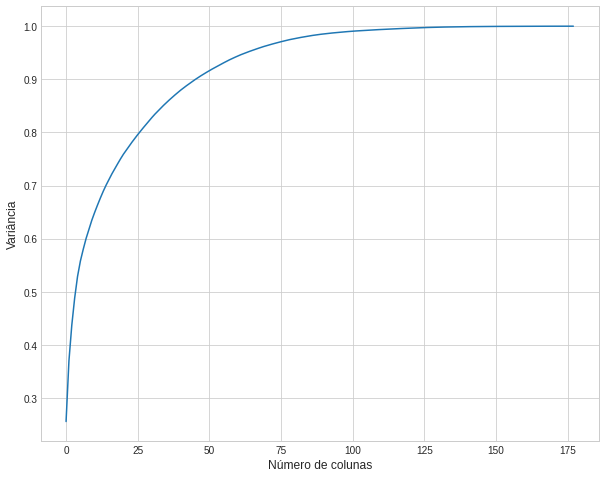

In [47]:
plt.xlabel('Número de colunas',size='large')
plt.ylabel('Variância',size='large')
plt.plot(pca.explained_variance_ratio_.cumsum())

In [48]:
#Com 100 colunas já atinge aproximadamente 100% da variância
pca = PCA(n_components=100)
pca_samples = pca.fit_transform(df)
pca_df = pd.DataFrame(pca_samples,index=df.index)

In [58]:
pca_df.shape

(23210, 100)

In [62]:
# When K increases(n centroides), the centroids are closer to the clusters centroids.
# The improvements will decline, at some point rapidly, creating the elbow shape.
# That point is the optimal value for K.

distancias = []                         #Sum of squared distances of samples to their closest cluster center
clusters = list(range(1,101))
for i in clusters:
    k_means = KMeans(n_clusters=i,random_state=42)
    k_means.fit(pca_df)
    distancias.append(k_means.inertia_)
    if not(i%10): print('foi o',i)
  

foi o 10
foi o 20
foi o 30
foi o 40
foi o 50
foi o 60
foi o 70
foi o 80
foi o 90
foi o 100


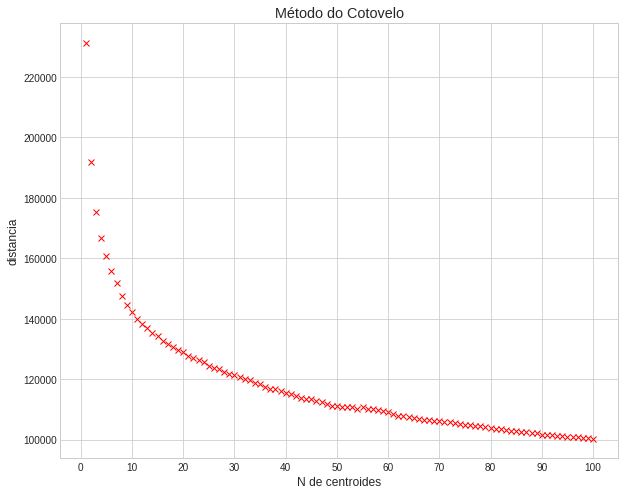

In [76]:
plt.title('Método do Cotovelo',size='x-large')
plt.xlabel('N de centroides',size='large')
plt.ylabel('distancia',size='large')
plt.xticks(list(range(0,101,10)))
plt.plot(clusters,distancias,'rx')

In [79]:
n_clusters=10
k_means = KMeans(n_clusters=n_clusters,random_state=42)
k_means.fit(pca_df)
c_preds = k_means.predict(pca_df)

In [80]:
df['cluster'] = c_preds
df.head()

,LOUCA,MARGARINA,FRUTAS,SALGADOS/APERITIVOS,CREME PARA PENTEAR,CREME ASSADURA,ACHOCOLATADOS,MULTIUSO / LIMPA VIDROS,TORRADAS,BOMBONIERE,...,DOCES INDUSTRIALIZADOS,FERMENTOS,ENLATADOS,CADEADO,PAES,FECULA,POLPA DE FRUTA,SABONETES,LEITE PO,cluster
460297,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
460298,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
460299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
460300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
460301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [81]:
df['cluster'].value_counts(normalize=True)

0    0.662904
2    0.111461
8    0.065144
9    0.052477
4    0.032141
5    0.024558
6    0.016674
7    0.013830
1    0.011030
3    0.009780
Name: cluster, dtype: float64

In [92]:
#Taxa de cada item em cada cluster
for i in range(n_clusters):
    cluster = df[df['cluster']==i].drop('cluster',axis=1).sum()
    #cluster = cluster.sum() / len(cluster.index)
    print(cluster.sort_values(ascending=False)[:6])
    print('\n')

BISCOITO         1737.0
ARROZ            1339.0
DIANTEIRO        1325.0
REFRIGERANTES    1297.0
LEITE UHT        1125.0
IOGURTE          1121.0
dtype: float64


BISCOITO             1748.0
FRUTAS                358.0
LAVAGEM DE ROUPAS     320.0
MACARRAO              317.0
TEMPEROS              300.0
REFRESCOS             269.0
dtype: float64


FRUTAS       3170.0
LEGUMES       563.0
BISCOITO      416.0
IOGURTE       406.0
DIANTEIRO     374.0
VERDURAS      355.0
dtype: float64


TEMPEROS             1028.0
BISCOITO              842.0
LEGUMES               679.0
LAVAGEM DE ROUPAS     602.0
FRUTAS                581.0
LOUCA                 552.0
dtype: float64


TEMPEROS             1232.0
LAVAGEM DE ROUPAS    1056.0
BISCOITO              850.0
ARROZ                 759.0
MACARRAO              758.0
LOUCA                 659.0
dtype: float64


FRUTAS       2242.0
LEGUMES       417.0
BISCOITO      322.0
IOGURTE       214.0
LEITE UHT     135.0
TEMPEROS      130.0
dtype: float64


REFRESCOS 